### **ResNet Sandbox**

# Make sure you are using tf 2.0 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.utils import to_categorical
from matplotlib import pyplot

print('Importing')

Importing


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy
trainX, trainy, testX, testy = load_dataset('/content/gdrive/My Drive/')


(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


### Create models 

In [4]:
class Distiller(keras.Model):
    def __init__(self, student, teachers = []):
        super(Distiller, self).__init__()
        self.teachers = teachers
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teachers_predictions = 0
        for teacher in self.teachers : 
          teachers_predictions += teacher(x, training=False)
        
        teachers_predictions = teachers_predictions/len(self.teachers)


        with tf.GradientTape() as tape:
            # Forward pass of student
            
           
            student_predictions = self.student(x, training=True)
            

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teachers_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
           
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))


        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
       
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [5]:
# define model
verbose, epochs, batch_size = 0, 15, 64
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

def createTeacherModel(shape,n_outputs):
  n_feature_maps = 64
  input_layer = keras.layers.Input(shape = shape)

  # BLOCK 1

  conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
  conv_x = keras.layers.BatchNormalization()(conv_x)
  conv_x = keras.layers.Activation('relu')(conv_x)

  conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
  conv_y = keras.layers.BatchNormalization()(conv_y)
  conv_y = keras.layers.Activation('relu')(conv_y)

  conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
  conv_z = keras.layers.BatchNormalization()(conv_z)

  # expand channels for the sum
  shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
  shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

  output_block_1 = keras.layers.add([shortcut_y, conv_z])
  output_block_1 = keras.layers.Activation('relu')(output_block_1)

  # BLOCK 2

  conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
  conv_x = keras.layers.BatchNormalization()(conv_x)
  conv_x = keras.layers.Activation('relu')(conv_x)

  conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
  conv_y = keras.layers.BatchNormalization()(conv_y)
  conv_y = keras.layers.Activation('relu')(conv_y)

  conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
  conv_z = keras.layers.BatchNormalization()(conv_z)

  # expand channels for the sum
  shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
  shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

  output_block_2 = keras.layers.add([shortcut_y, conv_z])
  output_block_2 = keras.layers.Activation('relu')(output_block_2)

  # BLOCK 3

  conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
  conv_x = keras.layers.BatchNormalization()(conv_x)
  conv_x = keras.layers.Activation('relu')(conv_x)

  conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
  conv_y = keras.layers.BatchNormalization()(conv_y)
  conv_y = keras.layers.Activation('relu')(conv_y)

  conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
  conv_z = keras.layers.BatchNormalization()(conv_z)

  # no need to expand channels because they are equal
  shortcut_y = keras.layers.BatchNormalization()(output_block_2)

  output_block_3 = keras.layers.add([shortcut_y, conv_z])
  output_block_3 = keras.layers.Activation('relu')(output_block_3)

  # FINAL

  gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

  output_layer = keras.layers.Dense(n_outputs, activation='softmax')(gap_layer)

  model = keras.models.Model(inputs=input_layer, outputs=output_layer)

  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
  model.summary()

  return model


In [6]:
def createStudentModel(shape,n_outputs):
  n_feature_maps = 25
  input_layer = keras.layers.Input(shape = shape)

  # BLOCK 1

  conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
  conv_x = keras.layers.BatchNormalization()(conv_x)
  conv_x = keras.layers.Activation('relu')(conv_x)

  conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
  conv_y = keras.layers.BatchNormalization()(conv_y)
  conv_y = keras.layers.Activation('relu')(conv_y)

  conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
  conv_z = keras.layers.BatchNormalization()(conv_z)

  # expand channels for the sum
  shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
  shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

  output_block_1 = keras.layers.add([shortcut_y, conv_z])
  output_block_1 = keras.layers.Activation('relu')(output_block_1)

  # BLOCK 2

  conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
  conv_x = keras.layers.BatchNormalization()(conv_x)
  conv_x = keras.layers.Activation('relu')(conv_x)

  conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
  conv_y = keras.layers.BatchNormalization()(conv_y)
  conv_y = keras.layers.Activation('relu')(conv_y)

  conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
  conv_z = keras.layers.BatchNormalization()(conv_z)

  # expand channels for the sum
  shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
  shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

  output_block_2 = keras.layers.add([shortcut_y, conv_z])
  output_block_2 = keras.layers.Activation('relu')(output_block_2)

  # BLOCK 3

  conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
  conv_x = keras.layers.BatchNormalization()(conv_x)
  conv_x = keras.layers.Activation('relu')(conv_x)

  conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
  conv_y = keras.layers.BatchNormalization()(conv_y)
  conv_y = keras.layers.Activation('relu')(conv_y)

  conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
  conv_z = keras.layers.BatchNormalization()(conv_z)

  # no need to expand channels because they are equal
  shortcut_y = keras.layers.BatchNormalization()(output_block_2)

  output_block_3 = keras.layers.add([shortcut_y, conv_z])
  output_block_3 = keras.layers.Activation('relu')(output_block_3)

  # FINAL

  gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

  output_layer = keras.layers.Dense(n_outputs, activation='softmax')(gap_layer)

  model = keras.models.Model(inputs=input_layer, outputs=output_layer)

  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
  model.summary()

  return model


In [7]:
teachers = []
teachers_hist = []
teachers_acc = []
for i in range(3):
  model = createTeacherModel(shape=(128,9),n_outputs=n_outputs)
  teachers_hist.append(model.fit(trainX,trainy,epochs=epochs,batch_size=batch_size,verbose=verbose))
  teachers_acc.append(model.evaluate(testX,testy,batch_size=batch_size,verbose=0))
  teachers.append(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 64)      4672        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 64)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
tempeture = 1
tempeture_delta = 2
alpha = 0
alpha_delta = 0.2

student_hist = []
student_acc = []
tempeture_alpha = []
while alpha < 1 :
  tempeture = 1
  while tempeture < 10 :
    student = createStudentModel(shape=(128,9),n_outputs=n_outputs)

    distiller = Distiller(student=student,teachers=teachers)
    distiller.compile(
        optimizer= keras.optimizers.Adam(),
        metrics=[keras.metrics.CategoricalAccuracy()],
        student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=alpha,
        temperature=tempeture,
        )
    student_hist.append(distiller.fit(trainX,trainy,epochs=5))
    student_acc.append(distiller.evaluate(testX,testy))
    tempeture_alpha.append([tempeture,alpha])

    tempeture += tempeture_delta
  alpha += alpha_delta




Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
conv1d_44 (Conv1D)              (None, 128, 25)      1825        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 128, 25)      100         conv1d_44[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 128, 25)      0           batch_normalization_48[0][0]     
____________________________________________________________________________________________

[]

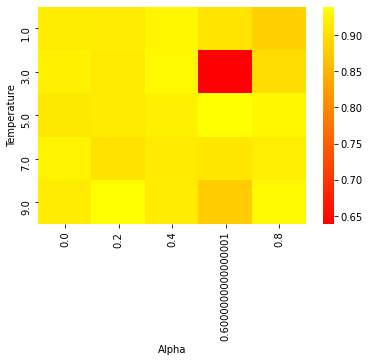

In [12]:
# HeatMap tempeter - alpha - accuracy
import pandas as pd
import seaborn as sns

student_acc_arr = np.array(student_acc)
tempeture_alpha_arr = np.array(tempeture_alpha)

heatmap = pd.DataFrame({'Temperature': tempeture_alpha_arr[:, 0], 'Alpha': tempeture_alpha_arr[:, 1], 'acc' : student_acc_arr[:,0] })

table = pd.pivot_table(heatmap, values='acc',
                       index=['Temperature'], 
                         columns=['Alpha'], aggfunc=np.mean)
ax = sns.heatmap(table,cmap='autumn')

pyplot.plot()

In [21]:
best_student = student_hist[17]

print("Best student accuracy :  : %g"% (student_acc_arr[17][0]))

Best student accuracy :  : 0.93926


In [16]:
for teacher in teachers :
  _, accuracy = teacher.evaluate(testX,testy,batch_size=batch_size,verbose=0)
  accuracy = accuracy * 100.0
  print("Teachers accuracy :  : %g"% (accuracy))

Teachers accuracy :  : 92.7384
Teachers accuracy :  : 92.2973
Teachers accuracy :  : 88.6664


In [17]:
student_iso = createStudentModel(shape=(128,9),n_outputs=n_outputs)

hist_non_dist = student_iso.fit(trainX,trainy,epochs=5,batch_size=batch_size,verbose=verbose)
_, accuracy = student_iso.evaluate(testX,testy,batch_size=batch_size,verbose=0)
accuracy = accuracy * 100.0
print("Student isoler accuracy :  : %g"% (accuracy))

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
conv1d_319 (Conv1D)             (None, 128, 25)      1825        input_30[0][0]                   
__________________________________________________________________________________________________
batch_normalization_348 (BatchN (None, 128, 25)      100         conv1d_319[0][0]                 
__________________________________________________________________________________________________
activation_261 (Activation)     (None, 128, 25)      0           batch_normalization_348[0][0]    
___________________________________________________________________________________________

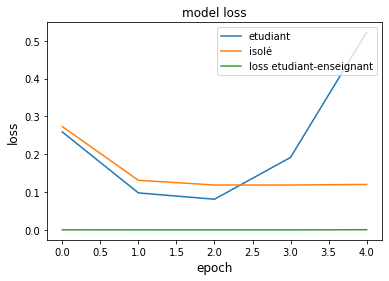

In [22]:
plt.figure()


plt.plot(best_student.history['student_loss'])
plt.plot(hist_non_dist.history['loss'])
plt.plot(best_student.history['distillation_loss'])

plt.title('model loss')
plt.ylabel('loss',fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['etudiant', 'isolé','loss etudiant-enseignant'], loc='upper right')
plt.show()
plt.close()